In [1]:
import datetime as dt
import io
import os
import requests

from coropy.compartmental_models import SEIRDModel, SEIRModel
from coropy.growth_models import GrowthCOVIDModel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize   
from sklearn.metrics import r2_score

import plotting

In [2]:
# configure plotting

plotting.configure(grid=True)
hex_blue = plotting.default_colors('blue')
hex_red = plotting.default_colors('red')
hex_purple = plotting.default_colors('purple')

In [3]:
# data from koronavirus.hr -- machine readable data

URLs = [
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/confirmed_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/recovered_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/death_cases.dat',
    'https://raw.githubusercontent.com/antelk/covid-19/master/data/CRO/tests.dat'
]

data = []
for URL in URLs:
    response = requests.get(URL)
    data.append(np.loadtxt(io.BytesIO(response.content)))
    
cum_positives, recovered, deceased, tests = data
removed = recovered - deceased
active = cum_positives - removed

    
# start of different epi waves
eff_dates = [dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 10), dt.datetime(2020, 8, 10)]

diff_1 = (eff_dates[1] - eff_dates[0]).days
diff_2 = (eff_dates[2] - eff_dates[1]).days

cum_positives_1 = cum_positives[:diff_1]
cum_positives_2 = cum_positives[diff_1:diff_1+diff_2]
cum_positives_3 = cum_positives[diff_1+diff_2:]

active_1 = active[:diff_1]
active_2 = active[diff_1:diff_1+diff_2]
active_3 = active[diff_1+diff_2:]

recovered_1 = recovered[:diff_1]
recovered_2 = recovered[diff_1:diff_1+diff_2]
recovered_3 = recovered[diff_1+diff_2:]

deceased_1 = deceased[:diff_1]
deceased_2 = deceased[diff_1:diff_1+diff_2]
deceased_3 = deceased[diff_1+diff_2:]

removed_1 = removed[:diff_1]
removed_2 = removed[diff_1:diff_1+diff_2]
removed_3 = removed[diff_1+diff_2:]

tests_1 = tests[:diff_1]
tests_2 = tests[diff_1:diff_1+diff_2]
tests_3 = tests[diff_1+diff_2:]

# Exponential extrapolation

In [4]:
y = cum_positives[-15:]  # last month data confirmed cases

In [5]:
model = GrowthCOVIDModel(function='exponential', normalize=True, calc_ci=True)
model.fit(y)
x_fit, y_fit = model.get_fitted
x_ext, y_ext = model.predict(5)  # extrapolate the following month

In [6]:
t_fit = np.arange(x_fit.size)
end_fit = dt.datetime.today()
start_fit = end_fit - dt.timedelta(int(t_fit.size))
t_fit = matplotlib.dates.drange(start_fit, end_fit, dt.timedelta(days=1))

t_ext = np.arange(x_ext.size)
start_ext = end_fit
end_ext = start_ext + dt.timedelta(int(t_ext.size))
t_ext = matplotlib.dates.drange(start_ext, end_ext, dt.timedelta(days=1))

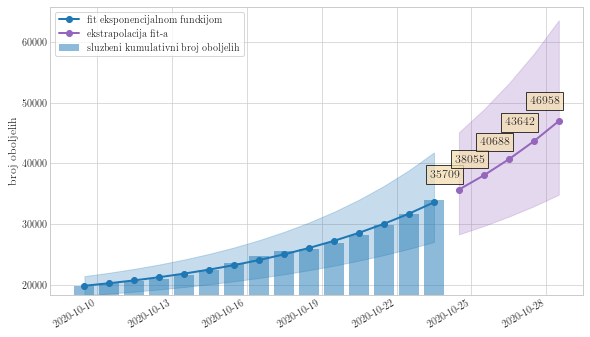

In [7]:
fig = plt.figure()
ax = fig.add_subplot()

ax.bar(t_fit, y - y_fit[0][0], bottom=y_fit[0][0], color=hex_blue, alpha=0.5, label='sluzbeni kumulativni broj oboljelih')
ax.fill_between(t_fit, y_fit[0], y_fit[2], color=hex_blue, alpha=0.25)
ax.plot(t_fit, y_fit[1], 'o-', color=hex_blue, linewidth=2, label='fit eksponencijalnom funckijom')

ax.fill_between(t_ext, y_ext[0], y_ext[2], color=hex_purple, alpha=0.25)
ax.plot(t_ext, y_ext[1], 'o-', color=hex_purple, linewidth=2, label='ekstrapolacija fit-a')

for val_t, val_y in zip(t_ext, y_ext[1]):
    ax.text(
        val_t, val_y + 0.07*val_y, f'{int(val_y)}', 
        horizontalalignment='right', verticalalignment='center',
        bbox=dict(facecolor='wheat', alpha=0.75))

ax.set_ylabel('broj oboljelih')
_ = fig.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=3))
_ = plt.gcf().autofmt_xdate()
plt.legend(loc='upper left', frameon=True)
plt.show()

# First wave simple SEIR extrapolation, full period fit + MCMC

In [8]:
# utils

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


# epi models

def SEIR(t, y, beta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I,  ##
        gamma*I,
    ]


def SEIR_extended(t, y, beta, delta, alpha, gamma):
    S, E, I, R = y
    N = S + E + I + R
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E,
        alpha*E - gamma*I,
        gamma*I,
    ]


def SEIRD(t, y, beta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R
    return [
        -beta*S*I/N, 
        beta*S*I/N - alpha*E, 
        alpha*E - gamma*I -mu*I,
        gamma*I,
        mu*I,
    ]


def SEIRD_extended(t, y, beta, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*E, 
        beta*S*I/N - alpha*E + delta*E, 
        alpha*E - gamma*I - mu*I,
        gamma*I,
        mu*I,
    ]

In [9]:
# loss function

def loss(params, active, IC):
    size = active.size
    sol = solve_ivp(
        fun=SEIR, 
        t_span=(0, size), 
        y0=IC, 
        args=params,
        method='RK45', 
        t_eval=np.arange(0, size, 1), 
        vectorized=True,
    )
    return MSE(sol.y[2], active)

In [10]:
t = np.arange(active_1.size)
end_dt = eff_dates[0] + dt.timedelta(int(t.max())+1)
dates = matplotlib.dates.drange(eff_dates[0], end_dt, dt.timedelta(days=1))
n_future = 45
t_opt = t[:-n_future]
dates_opt = dates[:-n_future]
t_ext = t[-n_future:]
dates_ext = dates[-n_future:]

In [11]:
guess = [0.1, 0.1, 0.1]
S0 = 2_800  # crude approx.
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

[fit] S = 37.95199446997282 
[fit] r2 = 0.9947652600635483 
[ext] S = 48.768186168844224 
[ext] r2 = 0.9457418404465169


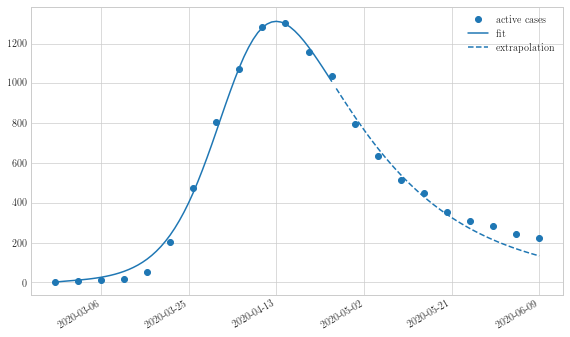

In [12]:
opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_1[:-n_future], IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, t_opt.size), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=t_opt, 
    vectorized=True,
)

predict = solve_ivp(
    fun=SEIR, 
    t_span=(0, t.size),
    y0=IC,
    args=opt.x,
    method='RK45',
    t_eval=t, 
    vectorized=True,
    )

# goodness-of-fit
sre_fit = np.sqrt(np.mean((active_1[:-n_future] - sol.y[2])**2))
r2_fit = r2_score(active_1[:-n_future], sol.y[2])
sre_ext = np.sqrt(np.mean((active_1[-n_future:] - predict.y[2][-n_future:])**2))
r2_ext = r2_score(active_1[-n_future:], predict.y[2][-n_future:])
print(
    f'[fit] S = {sre_fit}',
    f'\n[fit] r2 = {r2_fit}',
    f'\n[ext] S = {sre_ext}',
    f'\n[ext] r2 = {r2_ext}'
)

fig = plt.figure()
plt.plot(dates, active_1, 'o', color=hex_blue, markevery=5, label='active cases')
plt.plot(dates_opt, sol.y[2], '-', color=hex_blue, label='fit')
plt.plot(dates_ext, predict.y[2][-n_future:], '--', color=hex_blue, label='extrapolation')
_ = fig.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [13]:
from coropy.compartmental_models import SEIRModel

pcr_sens = 0.9
pcr_spec = 0.95
active_lb_ci, active_lb, active_ub, active_ub_ci = SEIRModel.calculate_ci(
    pcr_sens,
    pcr_spec,
    np.diff(np.concatenate((np.array([0]), cum_positives_1))),
    recovered_1 + deceased_1,
    tests_1)

In [14]:
guess = [0.1, 0.1, 0.1]
S0 = 4_500
E0 = 10*active_1[0]
I0 = active_1[0]
R0 = removed_1[0]
IC = [S0, E0, I0, R0]

opt = minimize(
    fun=loss, 
    x0=guess,
    args=(active_1, IC),
    method='L-BFGS-B',
    bounds=[(1e-5, 1.0)] * len(guess),
    options={'maxiter': 1000, 'disp': True},
)

sol = solve_ivp(
    fun=SEIR, 
    t_span=(0, t[-1]), 
    y0=IC, 
    args=opt.x,
    method='RK45', 
    t_eval=np.arange(0, t.size, 1), 
    vectorized=True,
)


# metropolis-hastings
n_iters = 1000
I = active_1
I_sampled = np.zeros(shape=(n_iters, t.size))

for i in range(n_iters):
    noisy_S0 = np.random.normal(loc=S0, scale=0.2*S0)
    noisy_E0 = np.random.normal(loc=E0, scale=0.2*E0)
    noisy_params = np.random.normal(loc=opt.x, scale=0.2*opt.x, size=opt.x.size)
    noisy_sol = solve_ivp(
        SEIR,
        t_span=(0, int(t[-1])),
        y0=[noisy_S0, noisy_E0, I0, R0],
        args=noisy_params,
        method='RK45',
        t_eval=t,
        vectorized=True,
    )
    if np.mean(noisy_sol.y[2] / I):
        I = noisy_sol.y[2]
    
    I_sampled[i, :] = I

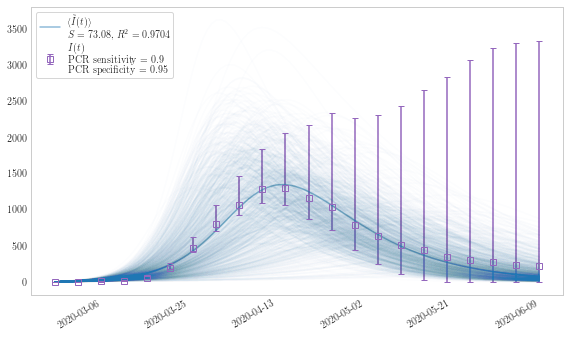

In [15]:
sre_fit = np.sqrt(np.mean((active_1 - sol.y[2])**2))
r2_fit = r2_score(active_1, sol.y[2])

fig = plt.figure()
plt.plot(dates, sol.y[2], '-', c=hex_blue, alpha=0.5, label=f'$\\langle \\tilde{{I}}(t) \\rangle$\n$S = {round(sre_fit, 2)}$, $R^2 = {round(r2_fit, 4)}$')
plt.plot(dates, I_sampled.T, c=hex_blue, alpha=0.01)
plt.errorbar(dates, active_1, 
             yerr=np.r_[
                 (active_1-active_lb).reshape(1, -1),
                 (active_ub-active_1).reshape(1, -1)],
             markevery=5,
             errorevery=5, capsize=3,
             marker='s', linestyle='None', mew=1, mfc='none',
             c=hex_purple,
             label=f'$I(t)$\nPCR sensitivity = ${pcr_sens}$\nPCR specificity = ${pcr_spec}$')

plt.legend(loc='upper left', frameon=True)
_ = fig.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

In [16]:
beta, delta, gamma = opt.x
print(f'beta = {beta}')
print(f'gamma = {gamma} -> t_rec = {1/gamma}')

beta = 0.24830312512885172
gamma = 0.0779592299026589 -> t_rec = 12.827217524449837


# First wave Heidler fit and extrapolation

In [17]:
# all data
DATA_DIR = 'data'
FILE_NAME = '1st_wave_data_cro.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
removed = cum_recovered + cum_deceased
active = cum_positives - removed

In [18]:
def heidler(t, t1, t2, n, a, b):
    exp_1 = 1 - np.exp(-t/t1)
    exp_2 = np.exp(-t/t2)
    # if np.sign is not used NumPy will generate RuntimeWarning: invalid value encountered in power
    # https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power#45384691
    return a/b * np.sign(exp_1) * (np.abs(exp_1))**np.abs(n) * exp_2  

In [19]:
n_fut = 15
y_train = active[:-n_fut]
y_test = active[-n_fut:]

In [20]:
model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=True)
model.fit(y_train)
x_fit, fitted = model.get_fitted

In [21]:
x_ext, extrapolated = model.predict(n_fut)

In [22]:
# prinout
sre_fit = np.sqrt(np.mean((y_train - fitted[1])**2))
r2_fit = r2_score(y_train, fitted[1])
sre_ext = np.sqrt(np.mean((y_test - extrapolated[1])**2))
r2_ext = r2_score(y_test, extrapolated[1])

t1, t2, n, a, b = model.get_params

print(
    f'Heidler function normalized parameters \n'
    f'--------------------------------------- \n'
    f'x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) \n'
    f'--------------------------------------- \n'
    f't1 = {t1}\n'
    f't2 = {t2}\n'
    f'n = {n}\n'
    f'a = {a}\n'
    f'b = {b}\n'
    f'\n'
    f'goodness-of-fit \n'
    f'--------------- \n'
    f'[fit] S = {sre_fit}\n'
    f'[fit] R2 = {r2_fit}\n'
    f'[fit] S = {sre_ext}\n'
    f'[fit] R2 = {r2_ext}\n'
    )

Heidler function normalized parameters 
--------------------------------------- 
x ∈ [0, 1] and y ∈ [0, 1] where y=f(x) 
--------------------------------------- 
t1 = 0.43192135375428015
t2 = 0.10450649186615651
n = 11.310973019320745
a = 5.204830980767677
b = 0.0006831305617691688

goodness-of-fit 
--------------- 
[fit] S = 23.1567890707582
[fit] R2 = 0.9974236479300971
[fit] S = 44.69134559458173
[fit] R2 = -0.5547566251988489



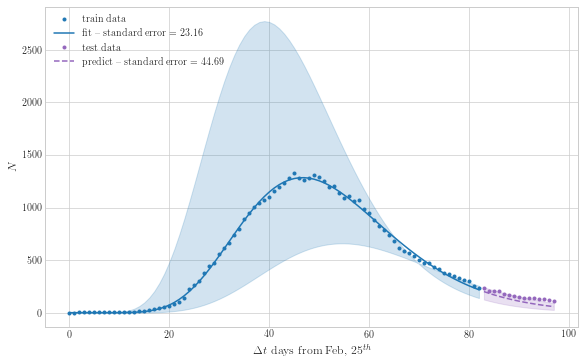

In [23]:
# visualize
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(x_fit, y_train, '.', color=hex_blue, label='train data')
ax.plot(x_fit, fitted[1], '-', color=hex_blue, label=f'fit -- standard error = {round(sre_fit, 2)}')
ax.fill_between(x_fit, fitted[0], fitted[2], color=hex_blue, alpha=0.2)
ax.plot(x_ext, y_test, '.', color=hex_purple, label='test data')
ax.plot(x_ext, extrapolated[1], '--', color=hex_purple, label=f'predict -- standard error = {round(sre_ext, 2)}')
ax.fill_between(x_ext, extrapolated[0], extrapolated[2], color=hex_purple, alpha=0.2)
ax.set_xlabel(r'$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel(r'$N$')
ax.legend(loc='upper left')
plt.show()